# Stock Predictor TFT Trainer

## Install dependencies

In [ ]:
pip install pytorch-lightning pytorch-forecasting pandas numpy matplotlib optuna optuna-integration[pytorch_lightning] pytorch_optimizer

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import optuna
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss, MAE
from lightning.pytorch import Trainer, Callback
import gc
import pickle
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# Load Training Data

In [5]:
import pandas as pd

data_path = "/kaggle/input/2025-03-27-training/2025-03-28 06_33_03.003994_training.csv"
merged_df = pd.read_csv(data_path)
print(len(merged_df))

# Features for input Data
merged_df.columns

252847


Index(['Unnamed: 0.1', 'Unnamed: 0', 'Date', 'Open', 'High', 'Low', 'Close',
       'Volume', 'Dividends', 'Stock Splits', 'month', 'day', 'day_of_week',
       'NASDAQ', 'SNP', 'DJI', 'RUT', 'VIX', 'XLK', 'XLE', 'XLF', 'XLV', 'RSI',
       'MA_20', 'MA_50', 'MA_200', 'log_return', 'RV_20', 'RV_50', 'symbol',
       'time_idx', 'sentiment'],
      dtype='object')

In [6]:
cols_to_convert = ['month', 'day', 'day_of_week']
merged_df[cols_to_convert] = merged_df[cols_to_convert].astype(str)
merged_df = merged_df[['Date', 'Open', 'High', 'Low', 'Close',
       'Volume', 'Dividends', 'Stock Splits', 'month', 'day', 'day_of_week',
       'NASDAQ', 'SNP', 'DJI', 'RUT', 'VIX', 'XLK', 'XLE', 'XLF', 'XLV', 'RSI',
       'MA_20', 'MA_50', 'MA_200', 'log_return', 'RV_20', 'RV_50', 'symbol',
       'time_idx', 'sentiment']]

In [7]:
merged_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,month,day,...,RSI,MA_20,MA_50,MA_200,log_return,RV_20,RV_50,symbol,time_idx,sentiment
0,2016-01-12,22.748425,22.780098,22.361553,22.614943,196616800,0.0,0.0,1,12,...,32.593251,23.860620,25.516840,26.797160,0.014409,0.272021,0.252555,AAPL,200,0.0
1,2016-01-13,22.696386,22.893215,22.013142,22.033503,249758400,0.0,0.0,1,13,...,29.187761,23.689921,25.419102,26.766218,-0.026047,0.280986,0.257305,AAPL,201,0.0
2,2016-01-14,22.162462,22.732588,21.660209,22.515396,252680400,0.0,0.0,1,14,...,31.365353,23.565829,25.323431,26.739852,0.021635,0.295712,0.260617,AAPL,202,0.0
3,2016-01-15,21.764275,22.105898,21.574234,21.974678,319335600,0.0,0.0,1,15,...,29.198463,23.405085,25.210684,26.710983,-0.024309,0.298984,0.262192,AAPL,203,0.0
4,2016-01-19,22.264271,22.318568,21.605912,21.868351,212350800,0.0,0.0,1,19,...,30.047150,23.265721,25.098379,26.680387,-0.004850,0.293998,0.262193,AAPL,204,0.0


In [8]:
# Ensure non NaN in input data
null_counts = merged_df.isna().sum()

# Display the result
print(null_counts)

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
month           0
day             0
day_of_week     0
NASDAQ          0
SNP             0
DJI             0
RUT             0
VIX             0
XLK             0
XLE             0
XLF             0
XLV             0
RSI             0
MA_20           0
MA_50           0
MA_200          0
log_return      0
RV_20           0
RV_50           0
symbol          0
time_idx        0
sentiment       0
dtype: int64


# Hyperparameter Tuning

In [ ]:
# Clear past logs for kaggle
!rm -r /kaggle/working/optuna_test/*

In [ ]:
!rm -r /kaggle/working/lightning_logs/*

In [11]:
# Define the custom callback
class GarbageCollectionCallback(Callback):
    def on_epoch_end(self, trainer: Trainer, pl_module):
        """
        This method is called at the end of each epoch. 
        It forces garbage collection to free up unused memory.
        """
        print(f"Epoch {trainer.current_epoch} ended. Running garbage collection...")
        gc.collect()  # Manually trigger garbage collection
        torch.cuda.empty_cache()  # Clear GPU cache
        print("Garbage collection triggered.")
      
    def on_train_end(self, trainer, pl_module):
        """
        This method is called once, after the entire training process is finished.
        """
        del trainer  # Delete the trainer object
        gc.collect()  # Manually trigger garbage collection
        print("Training has ended.")


# 1. Define the training dataset
max_prediction_length = 1   # Predict next 5 days
max_encoder_length = 10     # Use past 20 days for training

# training_cutoff = merged_df["time_idx"].max() - max_prediction_length
cutoff_date = '2025-02-10'
training_cutoff = 2320
print(f"cutoff_date: {cutoff_date}")
train_data = merged_df[merged_df["Date"] <= cutoff_date]
print(f"trainng data: {len(train_data)}")
val_data = merged_df[merged_df["Date"] > cutoff_date]
print(f"validation data: {len(val_data)}")

# Convert to PyTorch Forecasting Dataset
training = TimeSeriesDataSet(
    train_data,
    time_idx="time_idx",
    target="Close",
    group_ids=["symbol"],  
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["symbol"],
    time_varying_known_categoricals=['month', 'day', 'day_of_week'],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["Close", "Open", "High", "Low", "Volume", "RSI", "sentiment", "MA_20", "MA_50", "MA_200", "log_return", "RV_20", "RV_50", 'NASDAQ', 'SNP', 'DJI', 'RUT', 'VIX', 'XLK', 'XLE', 'XLF', 'XLV', 'RSI'],
    target_normalizer=GroupNormalizer(groups=["symbol"]),
    allow_missing_timesteps=True
)

validation = TimeSeriesDataSet.from_dataset(training, val_data, predict=True)

# Create DataLoaders
batch_size = 32
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=3)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=3)

cutoff_date: 2025-02-10
trainng data: 249743
validation data: 3104


/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/data/timeseries.py:1693: UserWarning: If predicting, no randomization should be possible - setting stop_randomization=True
  warnings.warn(


In [12]:
train_data.groupby("symbol")["Date"].count()

symbol
AAPL    2345
ABBV    2607
ABT     2284
ACN     2716
ADBE    2688
        ... 
V       2300
VZ      3008
WFC     2983
WMT     2284
XOM     2574
Name: Date, Length: 97, dtype: int64

In [ ]:
# Create hyper param tuning 
# loss_fn = QuantileLoss(quantiles=[0.5])
loss_fn = MAE()
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=20,
    max_epochs=10,
    gradient_clip_val_range=(0.1, 5.0),
    hidden_size_range=(100,128),
    hidden_continuous_size_range=(100,128),
    attention_head_size_range=(3, 4),
    learning_rate_range=(0.000001, 0.1),
    dropout_range=(0.1, 0.5),
    trainer_kwargs=dict(limit_train_batches=500, accelerator="auto"),
    reduce_on_plateau_patience=4,
    optimizer='adamw',
    loss=loss_fn,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

In [ ]:
print(study.best_trial.params)

In [ ]:
# Set the best hyper-parameter resulted from Optuna Tuning
learning_rate=study.best_trial.params['learning_rate']
hidden_size=study.best_trial.params['hidden_size']
attention_head_size=study.best_trial.params['attention_head_size']
dropout=study.best_trial.params['dropout']
hidden_continuous_size=study.best_trial.params['hidden_continuous_size']
gradient_clip_val=study.best_trial.params['gradient_clip_val']

# Train & Save the best Model 

In [ ]:
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch import Trainer

# Define the checkpoint callback to save the model
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",  # Directory to save checkpoints
    filename="tft_model-{epoch:02d}-{val_loss:.4f}",  # Save the model with epoch and validation loss
    monitor="val_loss",  # Monitor the validation loss for saving the best model
    mode="min",  # Save the model with the lowest validation loss
    save_top_k=1  # Save only the best model (change to save more if needed)
)

# Create the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (can also be 'val_accuracy', etc.)
    patience=8,          # Number of epochs with no improvement before stopping
    verbose=True,        # Print messages when stopping
    mode='min',          # 'min' for loss (lower is better), 'max' for accuracy (higher is better)
)


trainer = Trainer(
    max_epochs=50,
    accelerator="auto",
    enable_model_summary=True,
    gradient_clip_val=gradient_clip_val,
    callbacks=[checkpoint_callback, early_stopping],
)

loss_fn = QuantileLoss(quantiles=[0.5])

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=learning_rate,
    hidden_size=hidden_size,
    attention_head_size=attention_head_size,
    dropout=dropout,
    hidden_continuous_size=hidden_continuous_size,
    loss=MAE(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="adamw",
    reduce_on_plateau_patience=3,
)

In [ ]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [ ]:
print("Training Complete") 

# Visualization of Predicted curve

## Make Prediction

In [4]:
# Load Trained Model
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
# best_model_path = "/kaggle/input/tft_1.1/other/default/1/tft_model-epoch09-val_loss2.5493.ckpt"
best_tft = model #TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


### Prediction for a particular symbol

In [53]:
def display_prediction(symbol, input_size=2000, output_size=100):
    # Get Prediction Result
    stock_df = merged_df[merged_df['symbol'] == symbol]
    predict_df = stock_df.tail(windows).reset_index()
    pred_input_df = pd.concat([predict_df, predict_df.tail(1)], ignore_index=True)
    predictions = TimeSeriesDataSet.from_dataset(training, pred_input_df)
    pred_dataloader = predictions.to_dataloader(train=False, batch_size=batch_size)
    predictions_out = best_tft.predict(
        pred_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="auto")
    )
    predictions_q = best_tft.predict(pred_dataloader)
    median_forecast = predictions_q[:, 0]

    # Plotting
    import numpy as np
    pred_size = 100
    plt.plot(predict_df['Date'][-pred_size-1:].to_list() + ['next_day'], median_forecast.cpu()[-pred_size-2:], label="Predicted", color="blue", linewidth=2, linestyle="dashed")
    #plt.plot(low_forecast.cpu(), label="Lower Bound (5%)", color="red", linestyle="dashed")
    #plt.plot(high_forecast.cpu(), label="Upper Bound (95%)", color="green", linestyle="dashed")
    plt.plot(predict_df['Date'][-pred_size-1:], predict_df['Close'][-pred_size-1:], label="Actual", color="black")
    
    # # Labels and title
    plt.xlabel("Date")
    plt.xticks(fontsize=8) 
    plt.xticks(np.arange(0, len(predict_df['Date'][-pred_size-1:]), 30))
    plt.ylabel("Predicted Value")
    plt.title(f"{symbol} Forecast")
    plt.legend()
    plt.grid(True)
    plt.show()
    


INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/base_model.py:121: UserWarning: Not all dimensions are equal for tensors shapes. Example tensor torch.Size([32, 1, 4, 10]). Returning list instead of torch.Tensor.
  warnings.warn(
INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model

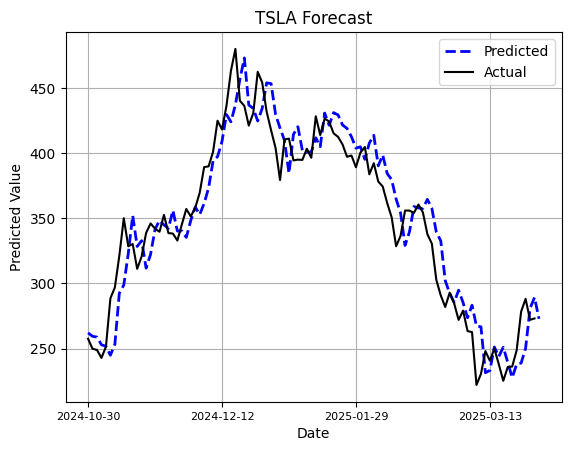

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/base_model.py:121: UserWarning: Not all dimensions are equal for tensors shapes. Example tensor torch.Size([32, 1, 4, 10]). Returning list instead of torch.Tensor.
  warnings.warn(
INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model

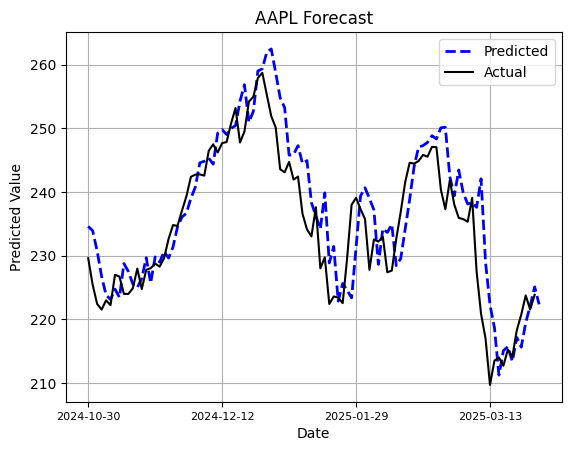

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


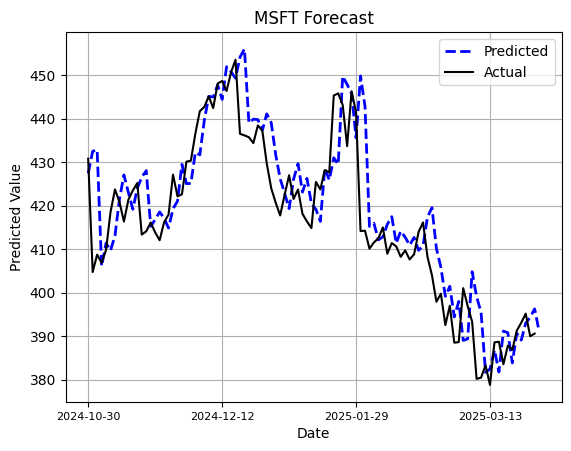

In [54]:
display_prediction("TSLA")
display_prediction("AAPL")
display_prediction("MSFT")

In [ ]:
# for idx in range(10):  # plot 10 examples
#     best_tft.plot_prediction(
#         predictions.x,
#         predictions.output,
#         idx=idx,
#         show_future_observed=True,
#     )